In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -U -r yolov5/requirements.txt  # install dependencies
%cd /content/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 7676, done.
remote: Counting objects: 100% (396/396), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 7676 (delta 246), reused 289 (delta 200), pack-reused 7280
Receiving objects: 100% (7676/7676), 9.09 MiB | 32.68 MiB/s, done.
Resolving deltas: 100% (5263/5263), done.
Requirement already up-to-date: matplotlib>=3.2.2 in /usr/local/lib/python3.7/dist-packages (from -r yolov5/requirements.txt (line 4)) (3.4.2)
Requirement already up-to-date: numpy>=1.18.5 in /usr/local/lib/python3.7/dist-packages (from -r yolov5/requirements.txt (line 5)) (1.21.0)
Requirement already up-to-date: opencv-python>=4.1.2 in /usr/local/lib/python3.7/dist-packages (from -r yolov5/requirements.txt (line 6)) (4.5.2.54)
Requirement already up-to-date: Pillow in /usr/local/lib/python3.7/dist-packages (from -r yolov5/requirements.txt (line 7)) (8.2.0)
Requirement already up-to-date: PyYAML>=5.3.1 in /usr/local/lib/python3.7/dist-packages (

In [ ]:
import torch
from IPython.display import Image  # for displaying images
from utils.google_utils import gdrive_download  # for downloading models/datasets
print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

torch 1.9.0+cu102 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
%cd /content/
!curl -L "https://app.roboflow.com/ds/Jt1kwageUz?key=GYbUjXSnr9" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0   2036      0 --:--:-- --:--:-- --:--:--  2031
100  576k  100  576k    0     0   914k      0 --:--:-- --:--:-- --:--:--  914k
Archive:  roboflow.zip
replace README.roboflow.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/s6_jpg.rf.ac999e4565f26c8745b448ce56b16037.jpg  
   creating: test/labels/
 extracting: test/labels/s6_jpg.rf.ac999e4565f26c8745b448ce56b16037.txt  
 extracting: train/images/s11_jpg.rf.11dcdce08fa2a4311ba4e8b72915e41f.jpg  
 extracting: train/images/s11_jpg.rf.c284730c6a184c3a077732d0ac2bbf0d.jpg  
 extracting: train/images/s11_jpg.rf.e98b4f13e258fbf7b264a3ce3419edd4.jpg  
 extracting: train/images/s1_jpg.rf.66678259b8adffd1c938ebc4

In [ ]:
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 1
names: ['shahid']

In [ ]:
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
%cat /content/yolov5/models/yolov5s.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C

In [ ]:
# Below we are changing the configuration so that it becomes compatible to number of classes required in this project
%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: 1  # number of classes  # CHANGED HERE
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

SyntaxError: ignored

In [ ]:
%writetemplate /content/yolov5/models/custom_yolov5s.yaml

UsageError: Line magic function `%writetemplate` not found.


In [ ]:
%cd /content/yolov5/
!python train.py --img 416 --batch 80 --epochs 100 --data './data.yaml' --cfg ./models/yolov5s.yaml --weights ''

/content/yolov5
train: weights=, cfg=./models/yolov5s.yaml, data=./data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=100, batch_size=80, img_size=[416], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket=, cache_images=False, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-252-g5ea771d torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/yolov5/runs

GROUND TRUTH TRAINING DATA:


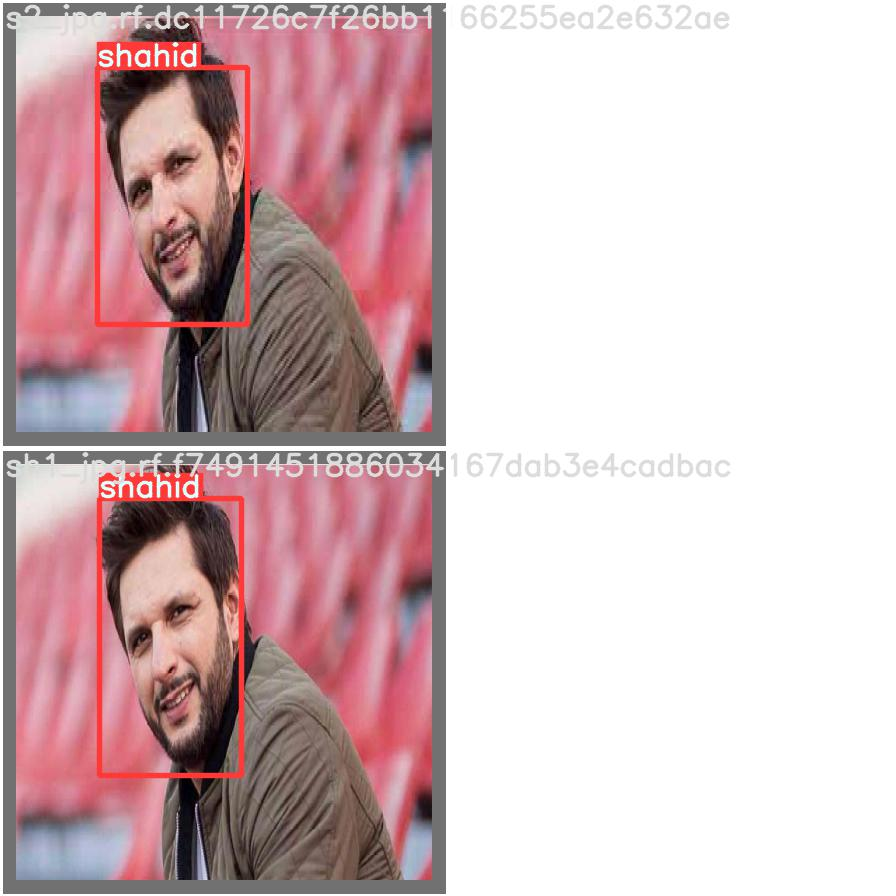

In [ ]:
# first, display our ground truth data
# The ground truth [Train data] is available in jpg file at location /content/yolov5/runs/train/exp2/test_batch0_labels.jpg 
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/exp/test_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


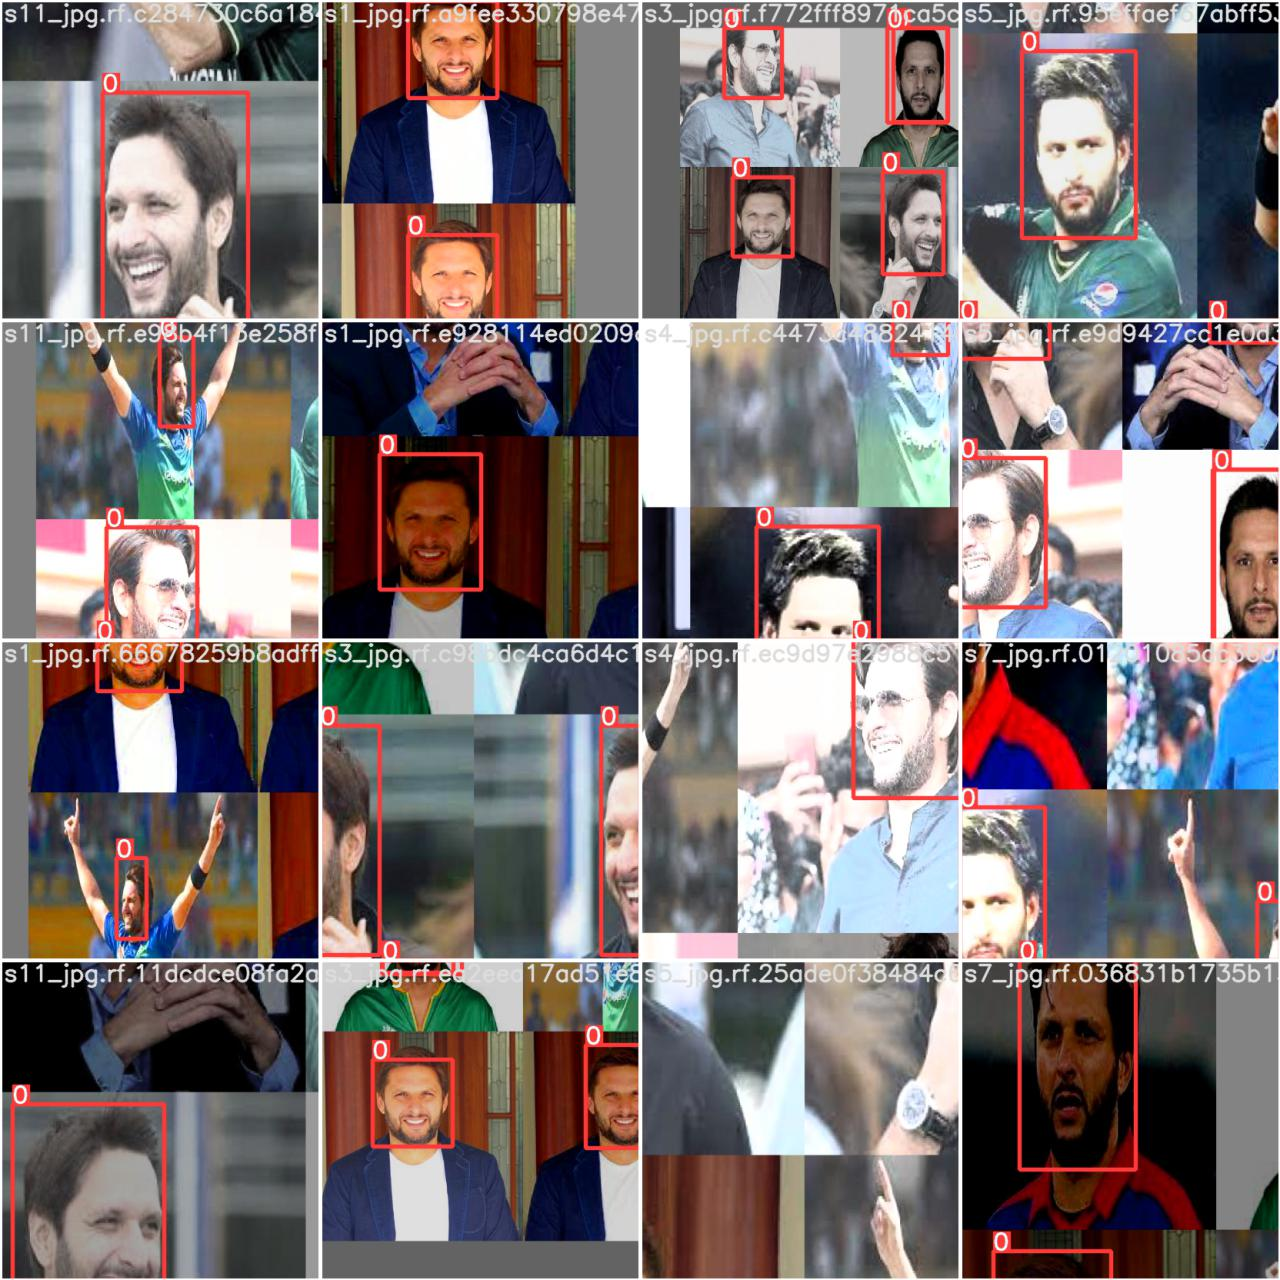

In [ ]:
# print out an augmented training example
# Below is the augmented training data.
# NOTE: The dataset already contains the augmented data with annotations, so that you dont have to do it.
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/exp/train_batch0.jpg', width=900)

In [ ]:
# use the best weights!
# Final weights will be by-default stored at /content/yolov5/runs/train/exp2/weights/best.pt
%cd /content/yolov5/
!python detect.py --weights /content/yolov5/runs/train/exp/weights/best.pt --img 416 --conf 0.4 --source ./test/images

/content/yolov5
detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=./test/images, imgsz=416, conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-252-g5ea771d torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7053910 parameters, 0 gradients, 16.3 GFLOPs
ima

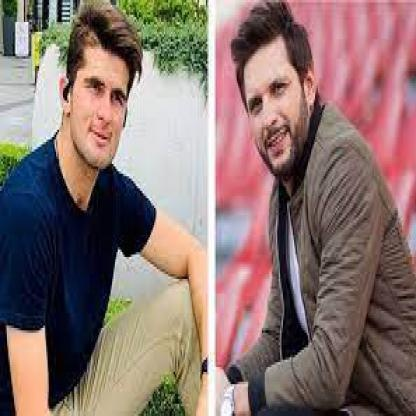

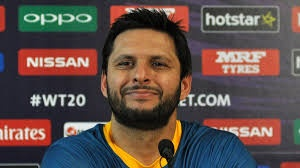

In [ ]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp7/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

In [ ]:
%cd /content/yolov5
!ls